# Predict House price

## Parameters

In [1]:
from pathlib import Path

# Directory of the csv 
BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04/examen_01')
# Images directory
IMAGES_DIR = BASE_DIR.joinpath('images','validate')

## Import

In [2]:
import pickle
with open(BASE_DIR.joinpath('house_scaler.xz'), 'rb') as f:
    scaler = pickle.load(f)

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
from keras.models import load_model
model = load_model(BASE_DIR.joinpath('house_model.h5'))

## Functions

### Prediction

In [5]:
from PIL import Image
def collage(images_dir, canvas_size=(1024,768)):
    # Resize images from images_dir to fit there
    new_size = (int(canvas_size[0]/2), int(canvas_size[1]/2))
    images_list = [Image.open(x).resize(new_size) for x in images_dir]

    # Create a canvas and paste the images as a collage
    canvas = Image.new('RGB', canvas_size, (255,255,255))
    canvas.paste(images_list[0], (0,0))
    canvas.paste(images_list[1], (new_size[0],0))
    canvas.paste(images_list[2], (0,new_size[1]))
    canvas.paste(images_list[3], (new_size[0],new_size[1]))
    
    return canvas

In [6]:
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def predict_house_price(img_obj, fit_model=model, scaler_obj=scaler):
    img = img_obj.resize(fit_model.layers[0].input_shape[1:3][::-1])
    img_array = np.asarray(img).astype('uint8')*1./255
    img_array = np.expand_dims(img_array, axis=0)
    prediction = fit_model.predict(img_array)
    return scaler_obj.inverse_transform(prediction)

### Full predict

In [7]:
import re
import pandas as pd

def full_predict(images_dir):
    to_predict = pd.DataFrame(sorted([x for x in images_dir.glob('*')]), columns=['fullpath'])
    to_predict['image_name'] = to_predict['fullpath'].astype(str).str.split('/').str[-1]
    to_predict['house_number'] = to_predict['image_name'].apply(lambda x: re.findall('(\d+)_',x)[-1])
    by_house = to_predict.pivot_table(index='house_number', values='fullpath', aggfunc=list)
    predictions = []
    for images in by_house['fullpath']:
        predictions.append(predict_house_price(collage(images)))
    predictions = [x[0][0] for x in predictions]
    by_house['price'] = predictions
    by_pic = by_house.join(by_house['fullpath'].apply(lambda x: str([str(y) for y in x]).replace('[','').replace(']','')).str.split(',', expand=True))
    by_pic = by_pic.melt(id_vars='price', ignore_index=False, value_vars=[0,1,2,3], value_name='file_name')
    by_pic['file_name'] = by_pic['file_name'].str.split('/').str[-1].str.replace("'",'')
    final = by_pic[['file_name','price']].reset_index(drop=True)
    return final

## Predict

,file_name,price
0,400_bathroom.jpg,553873.750
1,401_bathroom.jpg,553873.750
2,402_bathroom.jpg,585911.000
3,403_bathroom.jpg,560161.375
4,404_bathroom.jpg,588544.750


array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

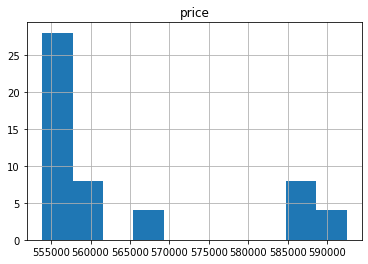

In [8]:
result = full_predict(IMAGES_DIR)
display(result.head())
display(result.hist())

## Export

In [9]:
result.to_csv(BASE_DIR.joinpath('KevFdez.csv'), index=False)